In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords
!pip install demoji
nltk.download('all')
import demoji

     |████████████████████████████████| 42 kB 772 kB/s 
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading packag

In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
import torchtext
from torchtext import data

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score, accuracy_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.9 MB 3.9 MB/s 
     |████████████████████████████████| 56 kB 5.9 MB/s 
     |████████████████████████████████| 3.3 MB 48.7 MB/s 
     |████████████████████████████████| 895 kB 69.2 MB/s 
     |████████████████████████████████| 596 kB 61.9 MB/s 


In [ ]:
demoji.download_codes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  """Entry point for launching an IPython kernel.


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_df = pd.read_csv("/content/drive/My Drive/NLP/data/labeledEn.csv")
main_df.head()

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1245138832040890370,A glass of wine keeps the corona away- DRAKE. ...,1,0,0,0,0,0,0,0,0,0,1
1,1245138859874234368,Can Anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1245138869353353222,Btw producers send me beats Im working on musi...,1,0,0,0,0,0,0,0,0,0,1
3,1245138873740648448,When someone you know.. apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1245138886172585989,"Dear soccer, I really miss you ,please come ba...",0,0,0,0,0,1,1,0,0,0,0


Text(0.5, 0, 'Count')

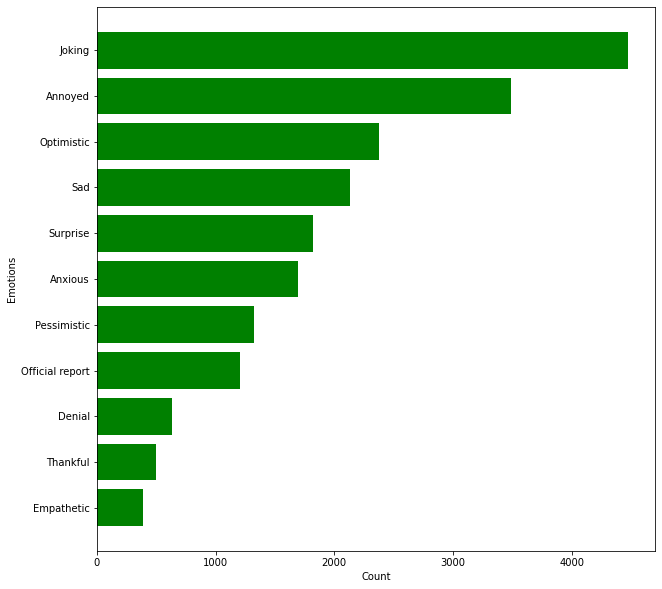

In [ ]:
emotions = list(main_df.columns[2:])
scores = [sum(main_df[x]) for x in emotions]
pairs = []

for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))

pairs = sorted(pairs, key = lambda x : x[1], reverse = False)
emotions_sorted = []
scores_sorted = []

for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [ ]:
rand_idx = np.random.randint(0, len(main_df))
print("Tweet : ", main_df.iloc[rand_idx]['Tweet'])
for e in emotions:
    print(e, ": ", main_df.iloc[rand_idx][e])

Tweet :  If you're okay with the coronavirus being called the Chinese virus, block me right now.
Optimistic :  0
Thankful :  0
Empathetic :  0
Pessimistic :  0
Anxious :  0
Sad :  0
Annoyed :  1
Denial :  0
Official report :  0
Surprise :  0
Joking :  0


In [ ]:
only_emotes = main_df[emotions]
only_emotes

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,0,0,0,0,0,0,1
9996,1,1,0,0,1,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,1,0
9998,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
emote_array = np.zeros((11, 11))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7, 'Official report' : 8,
    'Surprise' : 9, 'Joking' : 10
}
for i in range(len(only_emotes)):
    l = only_emotes.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

In [ ]:
emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)
emote_df

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,2373,235,171,226,246,291,379,72,156,387,982
1,235,498,28,15,41,29,67,14,70,98,92
2,171,28,389,18,50,71,41,7,7,24,63
3,226,15,18,1325,268,272,420,90,62,264,554
4,246,41,50,268,1695,360,452,95,138,357,510
5,291,29,71,272,360,2133,723,54,186,299,747
6,379,67,41,420,452,723,3492,261,122,536,1235
7,72,14,7,90,95,54,261,631,51,201,184
8,156,70,7,62,138,186,122,51,1207,284,95
9,387,98,24,264,357,299,536,201,284,1820,612


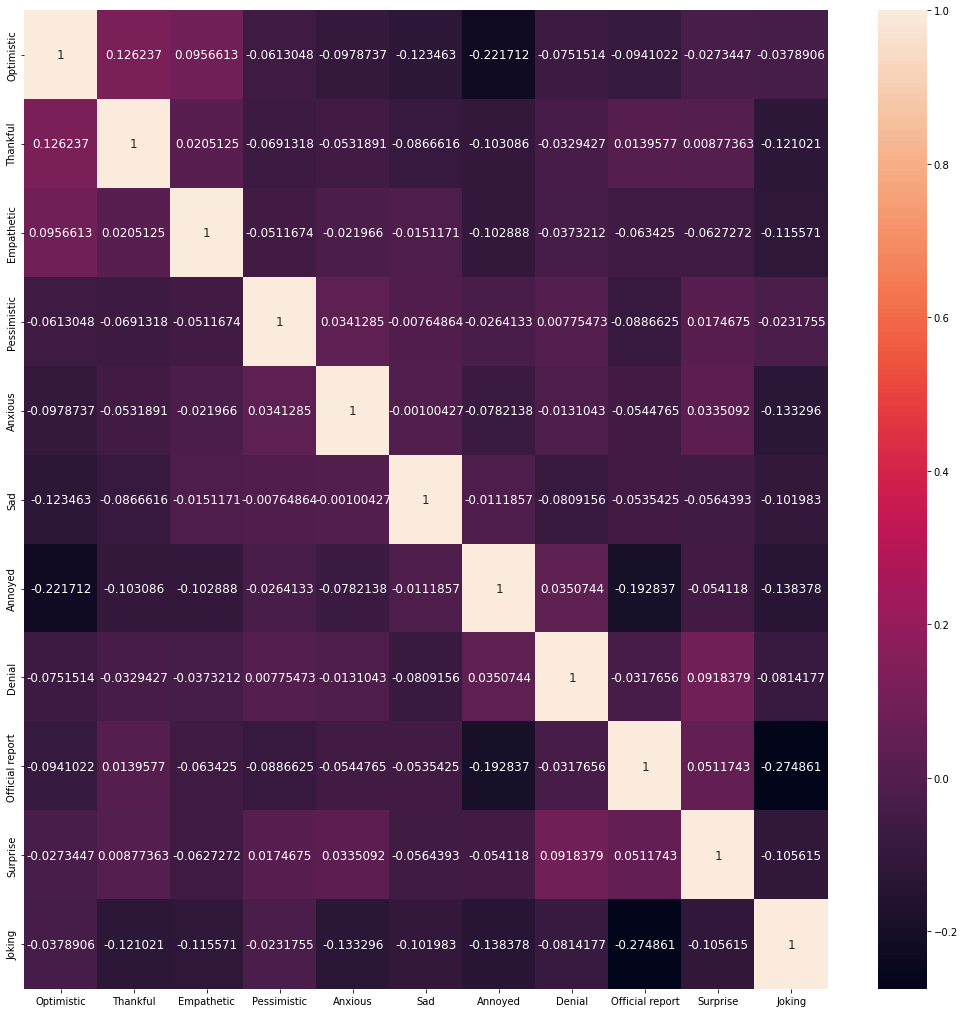

In [ ]:
fig = plt.figure(figsize = (18, 18))
sns.heatmap(only_emotes.corr(), annot = True, xticklabels = emote_df.columns, yticklabels = emote_df.columns, fmt = 'g', annot_kws = {"size" : 12})

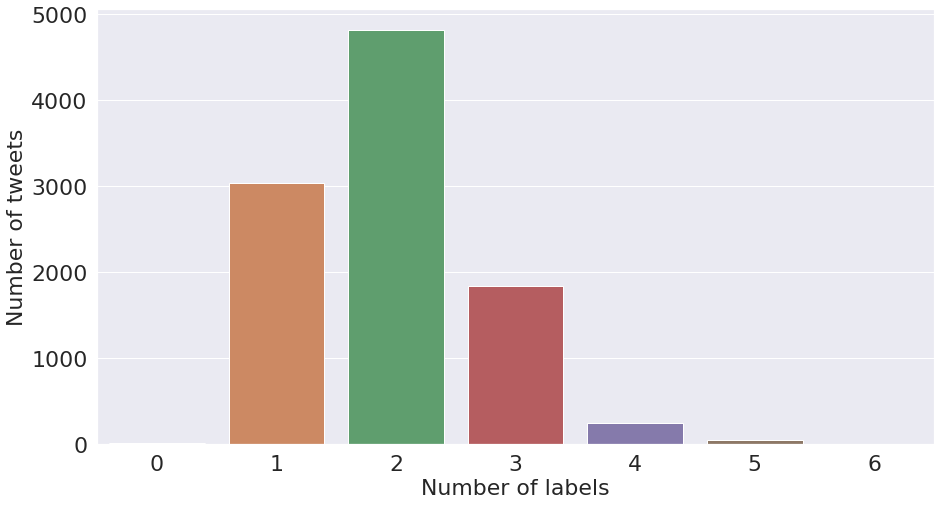

In [ ]:
main_df['n_emotions'] = main_df['Optimistic'] + main_df['Thankful'] + main_df['Empathetic'] + main_df['Pessimistic'] + main_df['Anxious'] + main_df['Sad'] + main_df['Annoyed'] + \
                        main_df['Official report'] + main_df['Surprise'] + main_df['Joking']
rowSums = main_df['n_emotions']
multiLabel_counts = rowSums.value_counts()

sns.set(font_scale = 2)
plt.figure(figsize = (15, 8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values, orient = 'v')

#plt.title("Tweets having multiple labels")
plt.ylabel('Number of tweets', fontsize = 22)
plt.xlabel('Number of labels', fontsize = 22)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    #ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
multiLabel_counts

2    4818
1    3034
3    1842
4     244
5      46
0      15
6       1
Name: n_emotions, dtype: int64

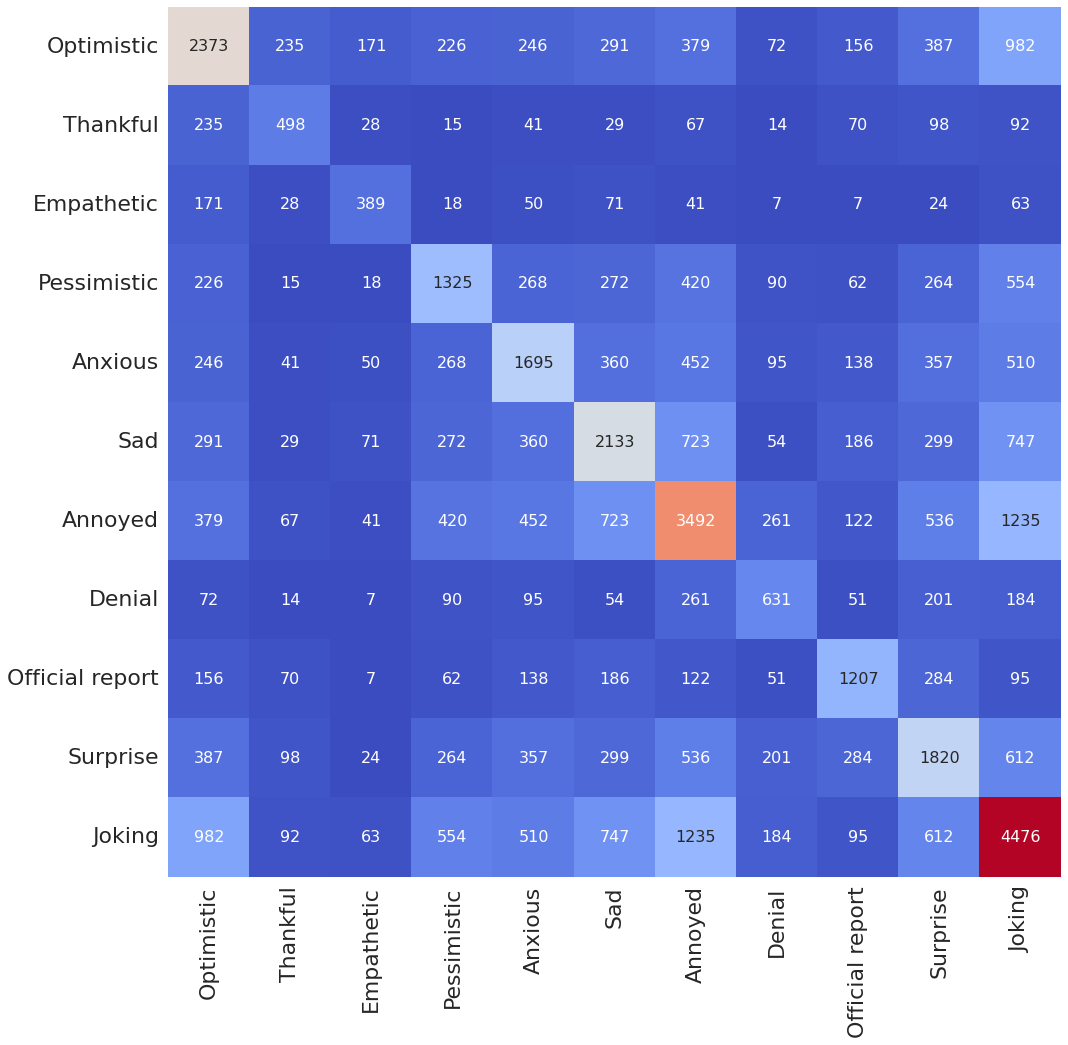

In [ ]:
fig = plt.figure(figsize = (16,16))
sns.set(font_scale = 2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns, 
            fmt = 'g', annot_kws = {"size" : 16}, cbar = False, cbar_kws = {"shrink": .8})

In [ ]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    StopWords = stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in StopWords]

In [ ]:
words = clean(''.join(str(main_df['Tweet'].tolist())))
words[:20]

['glass',
 'wine',
 'keep',
 'corona',
 'away',
 'drake',
 'se',
 'diga',
 'm',
 'cheer',
 'anyone',
 'tell',
 'took',
 'flu',
 'shot',
 'last',
 'year',
 'give',
 'positive',
 'result']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

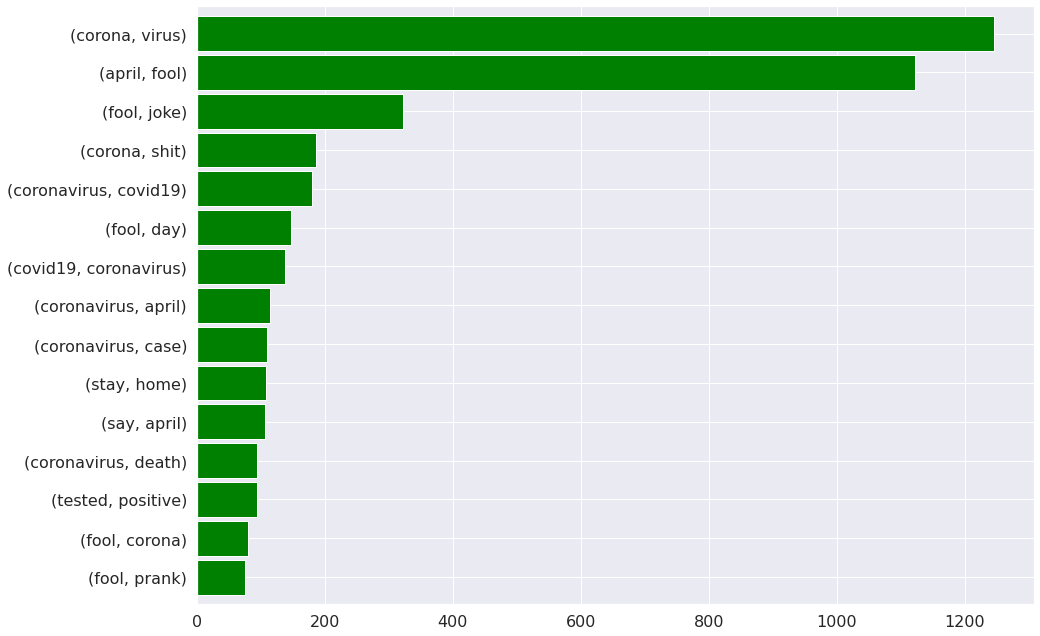

In [ ]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:15]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:15]

bigrams_series.sort_values().plot.barh(color = 'green', width = 0.9, figsize = (15, 11))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

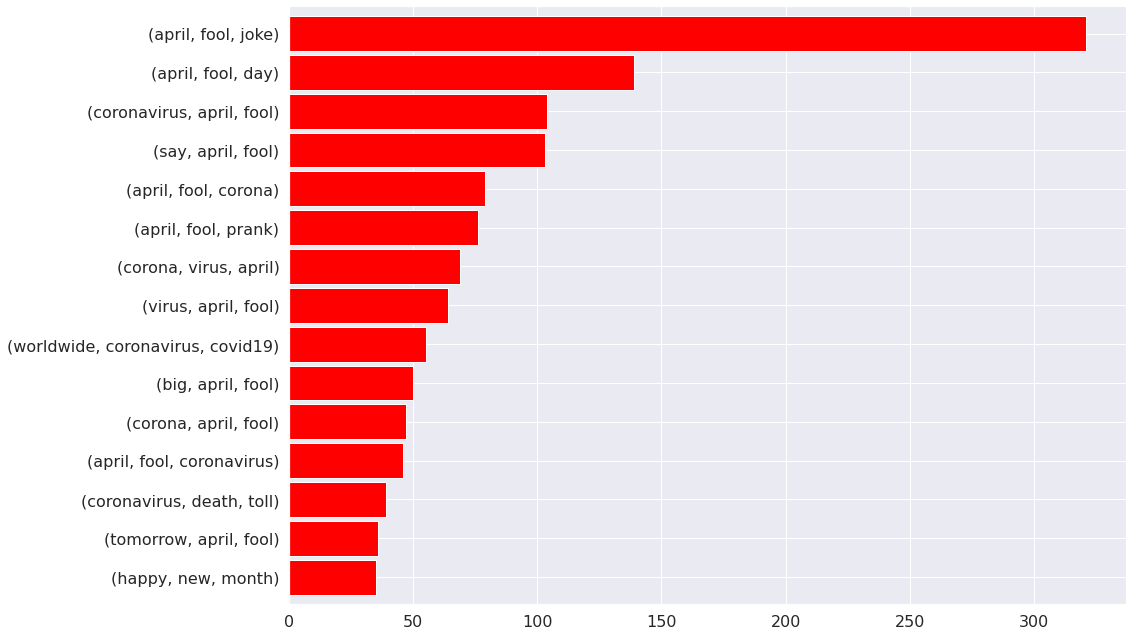

In [ ]:
trigrams_series.sort_values().plot.barh(color = 'red', width = 0.9, figsize = (15, 11))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

In [ ]:
pp_class = preprocess(main_df, contractions, contractionsWithAnotherInvertedComma)
main_df['Tweet'] = main_df['Tweet'].apply(lambda x : pp_class.preprocess_tweet(x))

In [ ]:
main_df['Tweet'] = main_df['Tweet'].str.lower()
main_df.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking,n_emotions
0,1245138832040890370,a glass of wine keeps the corona away drake ...,1,0,0,0,0,0,0,0,0,0,1,2
1,1245138859874234368,can anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0,2
2,1245138869353353222,by the way producers send me beats im working ...,1,0,0,0,0,0,0,0,0,0,1,2
3,1245138873740648448,when someone you know apart of your family d...,0,0,0,0,0,1,0,0,0,0,0,1
4,1245138886172585989,dear soccer i really miss you please come ba...,0,0,0,0,0,1,1,0,0,0,0,2
5,1245138911195803649,new home remedy to treat coronavirus tested b...,1,0,0,0,0,0,0,1,0,0,1,2
6,1245138920934969344,when xavier wulf does an attack on titan tape ...,0,0,0,0,0,0,0,0,0,0,1,1
7,1245138945119223814,mouthwash is hand san for your mouth and i do ...,0,0,0,0,0,1,0,0,0,1,1,3
8,1245138953302409216,yes all of them n france 1 000 christians to...,0,0,0,0,0,0,1,0,1,1,0,3
9,1245138958222311431,update i destroyed the tire honestly if i get ...,0,0,0,1,0,1,0,0,0,0,0,2


In [ ]:
def check_coverage(vocab, embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:
            oov[word] = vocab[word]
            i += vocab[word]
            pass
        
    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key = operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose = True):
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except:
                vocab[word] = 1
    return vocab

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path, encoding = "utf-8") as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [ ]:
GLOVE_EMBEDDING_FILE = '/content/drive/MyDrive/NLP/glove.840B.300d.txt'
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_FILE)
print(f'loaded {len(glove_embeddings)} word vectors ')

loaded 2196008 word vectors 


In [ ]:
vocab = build_vocab(list(main_df['Tweet'].apply(lambda x : x.split())))
oov = check_coverage(vocab, glove_embeddings)
oov[:10]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/14379 [00:00<?, ?it/s]

Found embeddings for 86.61% of vocab
Found embeddings for  96.72% of all text


[('covid19', 2241),
 ('covid', 408),
 ('aprilfoolsday', 135),
 ('stayathome', 73),
 ('aprilfools', 48),
 ('coronavirusoutbreak', 34),
 ('stayhome', 29),
 ('quarantinelife', 26),
 ('tablighijamaat', 25),
 ('fauci', 22)]

In [ ]:
main_df['Tweet'] = main_df['Tweet'].apply(lambda x : bruteGen(x))

In [ ]:
from sklearn.model_selection import train_test_split
sen_train, sen_test = train_test_split(main_df, train_size = 0.9, random_state = 1024)

sen_train.to_csv("train.csv", index = False)
sen_test.to_csv("test.csv", index = False)

sen_train.head(1)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking,n_emotions
560,1245143836667432960,minister for agriculture mahendra reddy to hol...,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

TWEET = torchtext.legacy.data.Field(sequential = True, lower = True, tokenize = tokenizer)
LABEL = torchtext.legacy.data.Field(sequential = False, use_vocab = False)

dataFields = [("ID", None), ("Tweet", TWEET), ("Optimistic", LABEL), ("Thankful", LABEL),
              ("Empathetic", LABEL), ("Pessimistic", LABEL), ("Anxious", LABEL), ("Sad", LABEL),
              ("Annoyed", LABEL), ("Denial", LABEL), ("Official report", LABEL),
              ("Surprise", LABEL), ("Joking", LABEL)]

train_dataset, test_dataset = torchtext.legacy.data.TabularDataset.splits(
    path = '/content/', train = 'train.csv', test = 'test.csv', format = 'csv', fields = dataFields, skip_header = True
    )

In [ ]:
print("Number of training samples : {}\n Number of testing samples : {}".format(len(train_dataset), len(test_dataset)))

Number of training samples : 9000
 Number of testing samples : 1000


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
TWEET.build_vocab(train_dataset, vectors = 'glove.840B.300d')

.vector_cache/glove.840B.300d.zip: 2.18GB [07:00, 5.17MB/s]                            
100%|█████████▉| 2196016/2196017 [03:13<00:00, 11374.26it/s]


In [ ]:
from torchtext.legacy import data

vocab = TWEET.vocab
BATCH_SIZE = 32
n_label = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter, test_iter = data.BucketIterator.splits(datasets = (train_dataset, test_dataset),
                                                   batch_size = BATCH_SIZE,
                                                   sort_key = lambda x : len(x.Tweet),
                                                   sort_within_batch = False,
                                                   repeat = False,
                                                   device = device)

In [ ]:
np.random.seed(1024)
for i in range(TWEET.vocab.vectors.shape[0]):
    vec = TWEET.vocab.vectors[i]
    if torch.sum(vec).item() == 0:
        a = np.random.uniform(-0.25, 0.25, 300)
        TWEET.vocab.vectors[i] = torch.from_numpy(a)

In [ ]:
batch = next(train_iter.__iter__()); batch


[torchtext.legacy.data.batch.Batch of size 32]
	[.Tweet]:[torch.cuda.LongTensor of size 28x32 (GPU 0)]
	[.Optimistic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Thankful]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Empathetic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Pessimistic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Anxious]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Sad]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Annoyed]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Denial]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Official report]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Surprise]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Joking]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [ ]:
#idea taken from http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
class BatchWrapper():
    def __init__(self, dl, x_var, y_vars):
        self.dl = dl
        self.x_var = x_var
        self.y_vars = y_vars

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var)
            if self.y_vars is not None:
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim = 1).float()
            else:
                y = torch.zeros((1))
            yield(x, y)
    
    def __len__(self):
        return len(self.dl)

In [ ]:
train_dl = BatchWrapper(train_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                              'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])
test_dl = BatchWrapper(test_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                            'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])

In [ ]:
class CustomLSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim, output_dim, drop_prob, bidirectional = False, use_glove = True):
        super().__init__()
        self.embeddings = nn.Embedding(len(vocab), embedding_dim)
        if use_glove:
            self.embeddings.weight.data.copy_(vocab.vectors)
            self.embeddings.weight.requires_grad = False
        self.drop_prob = drop_prob

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = bidirectional, batch_first = True, num_layers = 2)
        if bidirectional is True:
            self.lin = nn.Linear(2*hidden_dim, 64)
        else:
            self.lin = nn.Linear(hidden_dim, 64)
        self.fc = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(p = drop_prob)
    
    def forward(self, sentence):
        #sentence = [max_len, batch_size]

        embed = self.embeddings(torch.transpose(sentence, 0, 1))
        #embed = [batch_size, max_len, embedding_dim]
        
        if self.drop_prob:
            embed = self.dropout(embed)
        
        lstm_out, (hidden, cell) = self.lstm(embed)
        #lstm_out = [batch_size, max_len, 2*hidden_dim if bidirectional else hidden_dim]
        #hidden = [num_layers, batch_size, hidden_dim]
        #cell = [num_layers, batch_size, hidden_dim]
        
        out = lstm_out[:,-1,:].squeeze()
        #out = [batch_size, 2*hidden_dim if bidirectional else hidden_dim]
        
        out = self.lin(out)
        #out = [batch_size, 64]

        outputs = self.fc(out)
        #outputs = [batch_size, output_dim]
        
        return outputs

In [ ]:
def evaluation_metrics(actual_labels, pred_labels, threshold):
    int_pred_labels = pred_labels
    for i in range(len(pred_labels)):
        for j in range(11):
            if int_pred_labels[i][j] >= threshold: int_pred_labels[i][j] = 1
            else:
                int_pred_labels[i][j] = 0
    
    ham_loss = hamming_loss(actual_labels, int_pred_labels)
    jacc_score = jaccard_score(actual_labels, int_pred_labels, average = 'samples')
    lrap = label_ranking_average_precision_score(actual_labels, pred_labels)
    f1_macro = f1_score(actual_labels, int_pred_labels, average = 'macro')
    f1_micro = f1_score(actual_labels, int_pred_labels, average = 'micro')

    return ham_loss, jacc_score, lrap, f1_macro, f1_micro

In [ ]:
def train(model, loss_fn, optimizer, n_epochs, train_dl, threshold):

    train_losses = []  
    hamming_losses = []
    jaccard_scores = []
    lraps = []  
    iter = 1

    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        pred_labels = []
        actual_labels = []
        model.train()
        for x, y in train_dl:
            #print(x.shape, y.shape)
            optimizer.zero_grad()

            preds = model(x)

            m = nn.Sigmoid()
            sig_preds = m(preds)
            
            for tens in sig_preds:
                pred_labels.append(tens.cpu().detach().numpy())
            for tens in y:
                actual_labels.append(tens.cpu().detach().numpy())

            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.shape[0]

        ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        hamming_losses.append(ham_loss)
        lraps.append(lrap)
        jaccard_scores.append(jacc_score)
        '''
        if iter % 5 == 0:
            print("Epoch: ", epoch)
            print("Binary Cross Entropy With Logits Loss: {:.4f}".format(epoch_loss))
            print("Hamming Loss : {:.4f}".format(ham_loss))
            print("Jaccard Score: {:.4f}".format(jacc_score))
            print("Label Ranking Average Precision Score: {:.4f}".format(lrap))
            print("F1 Macro Score: {:.4f}".format(f1_macro))
            print("F1 Micro Score: {:.4f}".format(f1_micro))
            print("\n")
        iter += 1
        '''
    return train_losses, hamming_losses, jaccard_scores, lraps, f1_macro, f1_micro

In [ ]:
def test(model, loss_fn, test_dl, threshold):
    running_loss = 0.0
    pred_labels = []
    actual_labels = []
    model.eval()
    for x, y in test_dl:
        #print(x.shape, y.shape)

        preds = model(x)

        m = nn.Sigmoid()
        sig_preds = m(preds)
        
        for tens in sig_preds:
            pred_labels.append(tens.cpu().detach().numpy())
        for tens in y:
            actual_labels.append(tens.cpu().detach().numpy())

        loss = loss_fn(preds, y)

        running_loss += loss.item() * x.shape[0]

    ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

    test_loss = running_loss / len(test_dataset)
    return test_loss, ham_loss, jacc_score, lrap, f1_macro, f1_micro

In [ ]:
learning_rates = [1e-3]
hidden_dim = [128]
drop_probs = [0.7]

for drop_prob in drop_probs:
    bce_losses = []
    ham_losses = []
    jacc_scores = []
    lrap_scores = []
    f1_macros = []
    f1_micros = []
    for exp in range(1, 11):
        model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_fn = nn.BCEWithLogitsLoss()

        train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
        #all_models.append(model)

        test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
        bce_losses.append(test_loss)
        ham_losses.append(test_hamm_loss)
        jacc_scores.append(test_jacc_score)
        lrap_scores.append(test_lrap)
        f1_macros.append(test_f1_macro)
        f1_micros.append(test_f1_micro)
    
    print("Dropout = {}".format(drop_prob))
    print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(bce_losses)/10))
    print("Average Hamming Loss : {:.4f}".format(sum(ham_losses)/10))
    print("Average Jaccard Score: {:.4f}".format(sum(jacc_scores)/10))
    print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(lrap_scores)/10))
    print("Average F1 Macro Score: {:.4f}".format(sum(f1_macros)/10))
    print("Average F1 Micro Score: {:.4f}".format(sum(f1_micros)/10))
    print("\n\n")

    print("Deviation of Binary Cross Entropy With Logits Loss: {:.4f}".format(np.std(np.array(bce_losses))))
    print("Deviation of Hamming Loss : {:.4f}".format(np.std(np.array(ham_losses))))
    print("Deviation of Jaccard Score: {:.4f}".format(np.std(np.array(jacc_scores))))
    print("Deviation of Label Ranking Average Precision Score: {:.4f}".format(np.std(np.array(lrap_scores))))
    print("Deviation of F1 Macro Score: {:.4f}".format(np.std(np.array(f1_macros))))
    print("Deviation of F1 Micro Score: {:.4f}".format(np.std(np.array(f1_micros))))
    print("\n\n")

TypeError: ignored

In [ ]:
df = main_df.drop(['ID'], axis = 1)
df['list'] = df[df.columns[1:12]].values.tolist()
new_df = df[['Tweet', 'list']].copy()
new_df.head()

,Tweet,list
0,a glass of wine keeps the corona away drake ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,can anyone tell me if you took the flu shot la...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]"
2,by the way producers send me beats im working ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,when someone you know apart of your family d...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,dear soccer i really miss you please come ba...,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"


In [ ]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 4e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [ ]:
train_dataset = sen_train.drop(['ID'], axis = 1)
train_dataset['list'] = train_dataset[train_dataset.columns[1:12]].values.tolist()
train_df = train_dataset[['Tweet', 'list']].copy()
train_df = train_df.reset_index(drop = True)

test_dataset = sen_test.drop(['ID'], axis = 1)
test_dataset['list'] = test_dataset[test_dataset.columns[1:12]].values.tolist()
test_df = test_dataset[['Tweet', 'list']].copy()
test_df = test_df.reset_index(drop = True)

In [ ]:
training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.1)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()
    total_loss = 0

    for unw, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids, return_dict = False)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()

        if unw % 2000 == 0:
            print(f'Iter : {unw+1}, Epoch: {epoch+1}, Loss: {total_loss/(unw+1)}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
EPOCHS = 20
for epoch in range(EPOCHS):
    train(epoch)

Iter : 1, Epoch: 1, Loss: 0.024158025160431862
Iter : 2001, Epoch: 1, Loss: 0.09433966964578208
Iter : 4001, Epoch: 1, Loss: 0.0941287628787001
Iter : 6001, Epoch: 1, Loss: 0.09508617931261157
Iter : 8001, Epoch: 1, Loss: 0.09632988049647655
Iter : 1, Epoch: 2, Loss: 0.07188405841588974
Iter : 2001, Epoch: 2, Loss: 0.06785181015688016
Iter : 4001, Epoch: 2, Loss: 0.06874046596900742
Iter : 6001, Epoch: 2, Loss: 0.07050128220171581
Iter : 8001, Epoch: 2, Loss: 0.07099205353343271
Iter : 1, Epoch: 3, Loss: 0.014802396297454834
Iter : 2001, Epoch: 3, Loss: 0.05629556724566153
Iter : 4001, Epoch: 3, Loss: 0.05558721974390934
Iter : 6001, Epoch: 3, Loss: 0.05628279673272067
Iter : 8001, Epoch: 3, Loss: 0.05629640165764425
Iter : 1, Epoch: 4, Loss: 0.06150864064693451
Iter : 2001, Epoch: 4, Loss: 0.04187928369468444
Iter : 4001, Epoch: 4, Loss: 0.04446639966948125
Iter : 6001, Epoch: 4, Loss: 0.04432667295381826
Iter : 8001, Epoch: 4, Loss: 0.04582612781750421
Iter : 1, Epoch: 5, Loss: 0.005

In [ ]:
! pip install optuna
! pip install ray[tune]

     |████████████████████████████████| 308 kB 4.0 MB/s 
     |████████████████████████████████| 209 kB 72.6 MB/s 
     |████████████████████████████████| 80 kB 11.7 MB/s 
     |████████████████████████████████| 75 kB 5.4 MB/s 
     |████████████████████████████████| 111 kB 78.3 MB/s 
     |████████████████████████████████| 49 kB 7.5 MB/s 
     |████████████████████████████████| 144 kB 64.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=4c50a10595643e134caa522ca761c6e969cdeb4e37094c6fa79cfa9d5c39ea34
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 54.0 MB 67 kB/s 
     |████████████████████████████████| 72 kB 648 kB/s 
     |████████████████████████████████| 124 kB 63.9 MB/s 


In [ ]:
def model_init():
    return model.from_pretrained('bert-base-uncase', num_labels=11)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
def valid():
    model.eval()
    req_targets = []
    req_outputs = []
    valid_loss = 0

    with torch.no_grad():
        for unw, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            valid_loss += loss.item()

            req_targets.extend(targets.cpu().detach().numpy().tolist())
            req_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    valid_loss /= len(testing_loader)
    return req_outputs, req_targets, valid_loss

In [ ]:
from sklearn import metrics

outputs, targets, valid_loss = valid()

In [ ]:
outputs = np.array(outputs)
targets = np.array(targets)

In [ ]:
int_outputs = np.zeros((outputs.shape[0], outputs.shape[1]))

for row in range(outputs.shape[0]):
    for col in range(outputs.shape[1]):
        if outputs[row][col] >= 0.5: int_outputs[row][col] = 1

In [ ]:
targets[0], int_outputs[0], outputs[0]

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([6.24034692e-06, 1.07151418e-05, 1.98941179e-05, 1.37476263e-05,
        6.25484681e-05, 4.76568748e-05, 9.76616919e-01, 9.69865796e-05,
        2.60180495e-05, 6.14061544e-04, 9.99689937e-01]))

In [ ]:
bert_accuracy = accuracy_score(targets, int_outputs)
bert_ham_loss = hamming_loss(targets, int_outputs)
bert_jacc_score = jaccard_score(targets, int_outputs, average = 'samples')
bert_lrap = label_ranking_average_precision_score(targets, outputs)
bert_f1_macro = f1_score(targets, int_outputs, average = 'macro')
bert_f1_micro = f1_score(targets, int_outputs, average = 'micro')

In [ ]:
print("Test Accuracy:", bert_accuracy)
print("Test Loss:", valid_loss)
print("Hamming Loss:", bert_ham_loss)
print("Jaccard Score:", bert_jacc_score)
print("Label Ranking Average Precision Score:", bert_lrap)
print("F1 Macro Score:", bert_f1_macro)
print("F1 Micro Score:", bert_f1_micro)

Test Accuracy: 0.203
Test Loss: 0.9040389434667013
Hamming Loss: 0.155
Jaccard Score: 0.4814833333333333
Label Ranking Average Precision Score: 0.7343751136363653
F1 Macro Score: 0.5079789151635575
F1 Micro Score: 0.5622593068035943


In [ ]:
torch.save(model, f = '/content/drive/My Drive/NLP/bertmodel3.pth')
# you can save the fine-tuning model by this line.
#model.save_weights('bert_weights2.h5')

In [ ]:
bert = torch.load("/content/drive/My Drive/NLP/bertmodel3.pth")
bert

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
ieee = pd.read_csv("/content/drive/My Drive/NLP/vaccination_all_tweets.csv")
ieee['text'] = ieee['text'].str.lower()
ieee.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #sputnikv #astrazeneca #pfizerbio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"facts are immutable, senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain to me again why we need a vaccine @bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,there have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False
8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,covid vaccine; you getting it?\n\n #covidvacci...,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",Twitter Web App,2,1,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#covidvaccine \n\nstates will start getting #c...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False


In [ ]:
def emoji2text(tweet):
    emojis = demoji.findall(tweet)
    new_tweet = []
    for word in tweet.split():
        if word in emojis.keys():
            tweet = tweet.replace(word, emojis[word])
            new_tweet.append(emojis[word])
        wordmojis = demoji.findall(word)
        for char in word:
            if char in wordmojis.keys():
                tweet = tweet.replace(word, wordmojis[char])
    
    return tweet

def remove_hashtags(tweet):
    return re.sub(r'\#w+', '', tweet)

def remove_mentions(tweet):
    for word in tweet.split():
        if word[0] == '@':
            tweet = tweet.replace(word, '')
    return tweet

def remove_punctuations(tweet):
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')
    return tweet.translate(trantab)

def remove_url(text):
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags = re.MULTILINE)

def clean(tweet):
    tweet = emoji2text(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_mentions(tweet)
    #tweet = remove_punctuations(tweet)
    tweet = remove_url(tweet)
    return tweet

In [ ]:
ieee['text'] = ieee['text'].astype(str)
ieee['text'] = ieee['text'].astype(str)
ieee['text'] = ieee['text'].astype(str)
ieee['text'] = ieee['text'].apply(lambda x : clean(x))

In [ ]:
ieee

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #sputnikv #astrazeneca #pfizerbio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"facts are immutable, senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain to me again why we need a vaccine he...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202451,1444272468579979267,Sputnik V,"Moscow, Russia",Sputnik V is the world’s first registered COVI...,2020-08-11 09:12:38,869897,154,3473,True,2021-10-02 12:06:04,rdif: #sputnikv is already registered in 70 co...,['SputnikV'],Twitter Web App,78,369,False
202452,1444272466780688386,Sputnik V,"Moscow, Russia",Sputnik V is the world’s first registered COVI...,2020-08-11 09:12:38,869897,154,3473,True,2021-10-02 12:06:04,breaking | russia’s health minister mikhail mu...,['SputnikV'],Twitter Web App,586,1780,False
202453,1444263495982145536,VaxBLR,"Bengaluru, India",Hourly updates on FREE and PAID 18+ and 45+ va...,2021-06-21 08:44:34,26,0,0,False,2021-10-02 11:30:25,18-44 #bbmp #bengaluru #covidvaccine availabil...,"['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHI...",VaxBlr,0,1,False
202454,1444262957140041731,Sputnik V,"Moscow, Russia",Sputnik V is the world’s first registered COVI...,2020-08-11 09:12:38,869897,154,3473,True,2021-10-02 11:28:16,argentina’s ceo on #sputnikv authorization: ...,['SputnikV'],Twitter Web App,82,308,False


In [ ]:
ieee = ieee.dropna()
ieee = ieee.drop_duplicates(['text'])
ieee['text'] = ieee['text'].str.lower()
#ieee['month'] = ieee['month'].str.lower()
#ieee['place'] = ieee['place'].str.lower()
ieee['text'] = ieee['text'].apply(lambda x : re.sub('\n', '', x))

In [ ]:
ieee = ieee.reset_index()

In [ ]:
ieee.shape

(95364, 17)

In [ ]:
bert_df = pd.DataFrame()
#bert_df['Tweet'] = ieee['tweet']

bert_df[['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'Tweet', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet']] = ieee[['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet']]


values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * 95364
bert_df['list'] = values
bert_df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,Tweet,hashtags,source,retweets,favorites,is_retweet,list
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #sputnikv #astrazeneca #pfizerbio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#covidvaccine states will start getting #covid...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
test_dataset = CustomDataset(bert_df, tokenizer, MAX_LEN)

In [ ]:
bert_test_params = {'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0
                    }   

test_loader = DataLoader(test_dataset, **bert_test_params)

In [ ]:
def test():
    bert.eval()
    bert_outputs = []

    with torch.no_grad():
        for unw, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = bert(ids, mask, token_type_ids)

            bert_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return bert_outputs

In [ ]:
test_outputs = test()

In [ ]:
test_outputs = np.array(test_outputs)

for i in range(test_outputs.shape[0]):
    for j in range(test_outputs.shape[1]):
        if test_outputs[i][j] >= 0.5: test_outputs[i][j] = 1
        else: test_outputs[i][j] = 0

In [ ]:
bert_df['Optimistic'] = "None"
bert_df['Thankful'] = "None"
bert_df['Empathetic'] = "None"
bert_df['Pessimistic'] = "None"
bert_df['Anxious'] = "None"
bert_df['Sad'] = "None"
bert_df['Annoyed'] = "None"
bert_df['Denial'] = "None"
bert_df['Official report'] = "None"
bert_df['Surprise'] = "None"
bert_df['Joking'] = "None"
bert_df = bert_df.drop(['list'], axis = 1)

In [ ]:
for i in range(len(test_outputs)):
    bert_df['Optimistic'].iloc[i] = test_outputs[i][0]
    bert_df['Thankful'].iloc[i] = test_outputs[i][1]
    bert_df['Empathetic'].iloc[i] = test_outputs[i][2]
    bert_df['Pessimistic'].iloc[i] = test_outputs[i][3]
    bert_df['Anxious'].iloc[i] = test_outputs[i][4]
    bert_df['Sad'].iloc[i] = test_outputs[i][5]
    bert_df['Annoyed'].iloc[i] = test_outputs[i][6]
    bert_df['Denial'].iloc[i] = test_outputs[i][7]
    bert_df['Official report'].iloc[i] = test_outputs[i][8]
    bert_df['Surprise'].iloc[i] = test_outputs[i][9]
    bert_df['Joking'].iloc[i] = test_outputs[i][10]

In [ ]:
#bert_df['month'] = ieee['month']
#bert_df['place'] = ieee['place']

In [ ]:
df.head()

In [ ]:
bert_df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,Tweet,hashtags,source,retweets,favorites,is_retweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,0,0,0,0,0,0,0,0,1,1,0
1,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #sputnikv #astrazeneca #pfizerbio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,0,0,0,0,0,0,0,0,1,1,0
2,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,0,0,0,0,0,1,0,0,0,0,0
3,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#covidvaccine states will start getting #covid...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False,0,0,0,0,0,0,0,0,0,0,0
4,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,0,0,0,0,1,0,1,0,0,0,0


In [ ]:
bert_df.to_csv("/content/drive/My Drive/NLP/data/bert_final2.csv", index = False)

In [ ]:
contractions = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
"hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
"i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she shall / she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
"so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
"y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"
}

contractionsWithAnotherInvertedComma = { 
"ain’t": "am not", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",
"couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
"hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "he’s": "he is",
"how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
"i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",
"it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us",
"ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
"mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have",
"shan’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will",
"she’ll’ve": "she will have", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
"so’ve": "so have", "so’s": "so is", "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
"there’d’ve": "there would have", "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
"we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
"who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
"would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
"y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
"you’re": "you are", "you’ve": "you have"
}

In [ ]:
def bruteGen(tweet):
    tweet = tweet.replace("indiavscorona", "india versus coronavirus")
    tweet = tweet.replace("outbreakindia", "outbreak india")
    tweet = tweet.replace("real”", "real")
    tweet = tweet.replace("mutra", "urine")
    tweet = tweet.replace("fakenews", "fake news")
    tweet = tweet.replace("“omg", "oh my god")
    tweet = tweet.replace("“damn", "damn")
    tweet = tweet.replace("god’s", "gods")
    tweet = tweet.replace("lockdownextension", "lockdown extension")
    tweet = tweet.replace("कोरोना", "coronavirus")
    tweet = tweet.replace("indiathanks", "india thanks")
    tweet = tweet.replace("coronacoronavirus", "coronavirus")
    tweet = tweet.replace('coronavirusinsa', "coronavirus in south africa")
    tweet = tweet.replace('coronaviruscanada', 'coronavirus canada')
    tweet = tweet.replace('coronavirusau', 'coronavirus australia')
    tweet = tweet.replace('coronavirusaus', 'coronavirus australia')
    tweet = tweet.replace('cuomoprimetime', 'new york governor prime time')
    tweet = tweet.replace('letsfightcoronavirus', 'let us fight coronavirus')
    tweet = tweet.replace("covid19", "coronavirus")
    tweet = tweet.replace("covid", "coronavirus")
    tweet = tweet.replace("aprilfoolsday", "april fools day")
    tweet = tweet.replace("covidー19", "coronavirus")
    tweet = tweet.replace("stayathome", "stay at home")
    tweet = tweet.replace("“april", "april")
    tweet = tweet.replace("“i", "i")
    tweet = tweet.replace("aprilfools", "april fools")
    tweet = tweet.replace("coronavirusoutbreak", "coronavirus outbreak")
    tweet = tweet.replace("virusー19", "coronavirus")
    tweet = tweet.replace("fool’s", "fools")
    tweet = tweet.replace("what’s", "what is")
    tweet = tweet.replace("coronavirus”", "coronavirus")
    tweet = tweet.replace("fools”", "fools")
    tweet = tweet.replace("stayhome", "stay home")
    tweet = tweet.replace("quarantinelife", "quarantine life")
    tweet = tweet.replace("tablighijamaat", "muslims")
    tweet = tweet.replace("corona”", "coronavirus")
    tweet = tweet.replace("fauci", "physician")
    tweet = tweet.replace("april’s", "april")
    tweet = tweet.replace("pmkcallscurfewextension", "prime minister calls for curfew extension")
    tweet = tweet.replace("“virus", "coronavirus")
    tweet = tweet.replace("virus”", "coronavirus")
    tweet = tweet.replace("“corona", "coronavirus")
    tweet = tweet.replace("coronavirustruth", "coronavirus truth")
    tweet = tweet.replace("socialdistancing", "social distancing")
    tweet = tweet.replace("homestaysafe", "home stay safe")
    tweet = tweet.replace("“coronavirus", "coronavirus")
    tweet = tweet.replace("coronavirusupdate", "coronavirus update")
    tweet = tweet.replace("virusvirus", "coronavirus")
    tweet = tweet.replace("coronaviruspandemic", "coronavirus pandemic")
    tweet = tweet.replace("thelockdown", "the lockdown")
    tweet = tweet.replace("nizamuddin", "delhi")
    tweet = tweet.replace("trump’s", "donald trump")
    tweet = tweet.replace("“the", "the")
    tweet = tweet.replace("virus2019", "coronavirus")
    tweet = tweet.replace("indiafightscorona", "india fights coronavirus")
    tweet = tweet.replace("homesavelives", "home save lives")
    tweet = tweet.replace("everyone’s", "everyone")
    tweet = tweet.replace("coronariskforprisoners", "coronavirus risk for prisoners")
    tweet = tweet.replace("coronavirususa", "coronavirus usa")
    tweet = tweet.replace("tablighi", "mosque")
    tweet = tweet.replace("delhimarkaz", "delhi mosque")
    tweet = tweet.replace("coronajihad", "coronavirus struggle")
    tweet = tweet.replace("coronajihaad", "coronavirus struggle")
    tweet = tweet.replace("aprilfool", "april fool")
    tweet = tweet.replace("trumppressconference", "trump press conference")
    tweet = tweet.replace("i’m", "i am")
    tweet = tweet.replace("tigerking", "tiger king")
    tweet = tweet.replace("it’s", "it is")
    tweet = tweet.replace("trumpvirus", "trump virus")
    tweet = tweet.replace("today’s", "today is")
    tweet = tweet.replace("“you", "you")
    tweet = tweet.replace("“a", "a")
    tweet = tweet.replace("fools’", "fools")
    tweet = tweet.replace("rtgnews", "news")
    tweet = tweet.replace("19india", "india")
    tweet = tweet.replace("coronavirusindia", "coronavirus india")
    tweet = tweet.replace("y’all", "you all")
    tweet = tweet.replace("मीडिया", "media")
    tweet = tweet.replace("here’s", "here is")
    tweet = tweet.replace("“we", "we")
    tweet = tweet.replace("“fuck", "fuck")
    tweet = tweet.replace("flattenthecurve", "flatten the curve")
    tweet = tweet.replace("jammuandkashmir", "jammu and kashmir")
    tweet = tweet.replace("chriscuomo", "new york governor")
    tweet = tweet.replace("‘april", "april")
    tweet = tweet.replace("dranbumani", "doctor")
    tweet = tweet.replace("tndemandsmasstesting", "tamil nadu demands mass testing")
    tweet = tweet.replace("tabligi", "muslims")
    tweet = tweet.replace("don’t", "do not")
    tweet = tweet.replace("वायरस", "virus")
    tweet = tweet.replace("letsfightvirus", "let us fight virus")
    return tweet

In [ ]:
import string
import nltk
import csv
import re
import demoji
from nltk.stem.wordnet import WordNetLemmatizer

class preprocess():
    def __init__(self, df, contractions, otherContractions):
        self.df = df
        self.contractions = contractions
        self.otherContractions = otherContractions
    
    def lower(self, tweet):
        return tweet.lower()
    
    def abbreviate(self, tweet):
        tweet = tweet.split(' ')
        j = 0
        for str_ in tweet:
            fileName = '/content/drive/My Drive/NLP/Abbreviations.txt'
            accessMode = 'r'
            with open(fileName, accessMode) as csvfile:
                dataFromFile = csv.reader(csvfile, delimiter = '=')
                str_ = re.sub('[^a-zA-Z0-9-_.]', '', str_)
                for row in dataFromFile:
                    if str_.upper() == row[0]:
                        tweet[j] = row[1]
                csvfile.close()
            j += 1
        return ' '.join(tweet)
    
    def expand(self, tweet):
        for word in tweet.split():
            if word in self.contractions.keys():
                tweet = tweet.replace(word, self.contractions[word])
            elif word in self.otherContractions.keys():
                tweet = tweet.replace(word, self.otherContractions[word])
        return tweet
    
    def emoji2text(self, tweet):
        emojis = demoji.findall(tweet)
        new_tweet = []
        for word in tweet.split():
            if word in emojis.keys():
                tweet = tweet.replace(word, emojis[word])
                new_tweet.append(emojis[word])
            wordmojis = demoji.findall(word)
            for char in word:
                if char in wordmojis.keys():
                    tweet = tweet.replace(word, wordmojis[char])
        
        return tweet

    def remove_hashtags(self, tweet):
        return re.sub(r'\#w+', '', tweet)
    
    def remove_mentions(self, tweet):
        for word in tweet.split():
            if word[0] == '@':
                tweet = tweet.replace(word, '')
        return tweet

    def remove_punctuations(self, tweet):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return tweet.translate(trantab)
    
    def preprocess_tweet(self, tweet):
        tweet = self.lower(tweet)
        tweet = self.abbreviate(tweet)
        tweet = self.expand(tweet)
        tweet = self.emoji2text(tweet)
        tweet = self.remove_mentions(tweet)
        tweet = self.remove_hashtags(tweet)
        tweet = self.remove_punctuations(tweet)
        return tweet